In [1]:
cd ..


/


In [2]:
mkdir root/.kaggle

mkdir: cannot create directory ‘root/.kaggle’: File exists


In [0]:
api_token = {"username":"amarlatchireddy","key":"d1927120ebdf3ead33a9cda469c43340"}
import json
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
mkdir amazon_svm

mkdir: cannot create directory ‘amazon_svm’: File exists


In [5]:
cd amazon_svm

/amazon_svm


In [6]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip amazon-fine-food-reviews

Archive:  amazon-fine-food-reviews.zip
replace Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Reading data
## Loading data

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [9]:
conn=sqlite3.connect("database.sqlite")
data=pd.read_sql_query("SELECT * from reviews where Score!=3",conn)
def partition(x):
    if x>3:
        return 1
    return 0
actual=data['Score']
posneg=actual.map(partition)
data['Score']=posneg
data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
#deleting duplicate values
#sort data
sorted_data=data.sort_values('ProductId',axis=0,ascending=True,kind='quicksort')
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [13]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...




## Data balancing
## Sampling of data



In [0]:
# To randomly sample 20k points from both class
finalpos=final[final["Score"]==1].sample(n=20000)
finalneg=final[final["Score"]==0].sample(n=20000)
final_counts=pd.concat([finalpos,finalneg])

In [15]:
final_counts.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
13662,14914,B000DZKKKC,ANA2PVMARGY8H,"Sarah ""Bookworm/cat person""",1,1,1,1320624000,Delicious---just don't eat all of the batter f...,"Although I love to cook, I rarely if ever bake..."
299873,324818,B0006MUF6G,A3FM6X1GMBDYHD,"P. Radicchi ""pradicchio""",5,5,1,1220486400,Delicious Hot Lunch for the Office,"What a find! Spicy, delicious, vegan, lowfat,..."
369029,398988,B000QGG1M4,A2WL4YBYQJHCI,Carol Geck,0,0,1,1311120000,Chocolate Gold Coins,These gold coins were added to a bag of favors...
337407,365070,B001E95KUQ,A3L347HM99EL0T,Braden,3,3,1,1324512000,good for instant coffee,I think people giving this stuff bad reviews a...
338311,366048,B0052ENCWC,A3C3PWTS92IMN6,foster,0,0,1,1334188800,pretty good stuff,"Overall, I like this spiced cocoa. It's good p..."


In [0]:
finalcount=final_counts.sort_values('Time')

In [17]:
finalcount.head(30)                          

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...
138017,149789,B00004S1C6,A1KXONFPU2XQ5K,Stephanie Manley,26,28,1,965779200,A must have!,"These are easy to use, they do not make a mess..."
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...
333924,361311,B00005IX96,A24IUOMVERXVEG,"Rick ""rick_street""",11,11,1,1036108800,Great Easy cup of Espresso,I've purchased both the Espressione Espresso (...
346052,374356,B00004CI84,A3ICHEO78NFE4Y,Rick D. Barszcz,1,2,1,1042416000,Just plain fun!,I recently saw the DVD 5.1 version of this fil...
333923,361310,B00005IX96,A3DPP97CNG990R,"""websurpher""",12,12,1,1046044800,"Outstanding flavor, great price!",After years of using Starbuck's decaf and regu...
346095,374401,B00004CI84,A3M5O6UHXO9IBU,Gary,2,34,0,1052265600,Certificate: Puerile,Embarrassing comedy that comes over like a chi...
388413,419994,B0000A0BS5,A238V1XTSK9NFE,Andrew Lynn,46,59,0,1064361600,Not actually for use in espresso machines,Few things I'd like to point out:<p>1. &quot;...
250486,271595,B0000TU8VM,A3CBHCE5OH4P8V,Chris Chiquoine,5,6,1,1068249600,Unique and delicious,"A piquant, sweet, colorful treat. Don't be pu..."
255262,276741,B0000D9MUE,AJE3Y24PQQ0KY,valerie,1,1,1,1069027200,My favorite &quot;chevre&quot;,"This cheese is soft, a bit runny just inside t..."


In [18]:
finalcount['Score'].value_counts()

1    20000
0    20000
Name: Score, dtype: int64

## Data Cleaning

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
#setting stop words
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(finalcount['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 40000/40000 [00:16<00:00, 2367.15it/s]


In [0]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(preprocessed_reviews,finalcount['Score'],test_size=0.3)

In [0]:
#BOW
countvec=CountVectorizer()
xl_train=countvec.fit_transform(x_train)
xl_test=countvec.transform(x_test)

In [0]:


from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


## Applying Linear SVM on Bag Of Words

In [25]:
#hyper-parameter tuning simple cross validation
s=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for k in s:
    
    clf=SGDClassifier(loss='hinge',alpha=k)
    clf.fit(xl_train,y_train)
    pred=clf.predict(xl_test)
    acc=accuracy_score(y_test,pred,normalize=True)*float(100)
    print("The accuracy score for %f=%f%%"%(k,acc))

The accuracy score for 0.000010=85.341667%
The accuracy score for 0.000100=87.325000%
The accuracy score for 0.001000=88.016667%
The accuracy score for 0.010000=86.658333%
The accuracy score for 0.100000=81.708333%
The accuracy score for 1.000000=72.200000%
The accuracy score for 10.000000=60.575000%
The accuracy score for 100.000000=68.933333%
The accuracy score for 1000.000000=52.583333%
The accuracy score for 10000.000000=49.950000%


In [0]:
parameters=dict(alpha=s)
svm=SGDClassifier(loss='hinge')
gridcv=GridSearchCV(svm,parameters,cv=10,n_jobs=-1)

In [27]:
gridcv.fit(xl_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=F

In [28]:
print(gridcv.best_score_)
print(gridcv.best_params_)
print(gridcv.best_estimator_)

0.8748571428571429
{'alpha': 0.001}
SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
from sklearn.calibration import CalibratedClassifierCV

In [30]:
sgd = SGDClassifier(penalty='l2',alpha=0.001)
sgd.fit(xl_train,y_train)
feat_log = sgd.coef_

countsvect = CountVectorizer()
p = countsvect.fit_transform(x_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = countsvect.get_feature_names()


q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 10  important features of positive class", np.array(q['feature'][:10]))
print("Top 10  important features of negative class",np.array(q.tail(10)['feature']))

Top 10  important features of positive class ['delicious' 'excellent' 'perfect' 'great' 'pleased' 'smooth' 'loves'
 'yummy' 'wonderful' 'highly']
Top 10  important features of negative class ['bland' 'threw' 'weak' 'disappointed' 'horrible' 'awful' 'terrible'
 'disappointment' 'worst' 'disappointing']


In [31]:
clff=SGDClassifier(loss='hinge',alpha=0.001,class_weight='balanced')
clff.fit(xl_train,y_train)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
preds=clff.predict(xl_test)

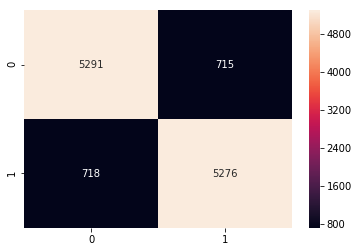

In [33]:
import seaborn as sns 
cm=confusion_matrix(y_test,preds)
sns.heatmap(cm,annot=True,fmt='d')




### Rbf kernal svm



In [0]:
from sklearn.svm import SVC
count_rbf = CountVectorizer(min_df=10, max_features=100)  #in scikit-learn
rbftr=count_rbf.fit_transform(x_train)
rbfts=count_rbf.transform(x_test)

In [0]:
parameters = {'C':[0.1, 1.0],
             'gamma':[0.0001, 0.01]}
classifier_ = SVC(C=0.001,kernel='rbf')
search_hyp = GridSearchCV(classifier_, parameters, cv=10, n_jobs=-1)

In [39]:
search_hyp.fit(rbftr,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=0.001, cache_size=200, class_weight=None,
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1.0], 'gamma': [0.0001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)